In [ ]:
## 종합 필요 library
import os 
import numpy as np 
import pandas as pd
from pathlib import Path
import dlib
import matplotlib.pyplot as plt
import cv2 as cv
from glob import glob
from os.path import isfile, join
from pprint import pprint
## Method #2
# import dlib.get_frontal_face_detector()
# import dlib.cnn_face_detection_model_v1(filepath)
# mmod_human_face_detector.dat 파일 필요

#### 생각해야 할 부분 
1. 이미지 기울어짐
2. 얼굴 정면이 아닐 때 (옆면)
3. 사람 이미지가 작을 때 
4. 한 화면 내 다수의 사람이 있을 때 -> *추후 진행 필요*
5. whiskers 뒤로 원본 이미지가 보여야 함
6. 이전 학습에서는 기존에 학습이 이미 되어있던 데이터를 이용해서 facial recognition을 진행함. 직접 할 수 있는 방법 확인 -> *추후 진행 필요*

* Node Tip.
  - cv2.addWeighted()


#### Facial Recognition Method
1. Max-Margin(MMOD) CNN
2. HOG + Linear SVM [dlib의 face_recognition 패키지]


* CNN으로 하면 hog + linear svm 보다는 느리지만 compile해서 진행하면 더 accurate하다. 
* 그러나 GPU 필요함. CPU로 할 시 느리기 때문
* HOG는 이미지 rotation에 민감하지 않음
* dlib.get_frontal_face_detector() 말고도 face_recognition이라는 것도 있음. git에서 찾기 
* See also: find_faces_in_picture_cnn.py
* face_locations = face_recognition.face_locations(image)

>> A HOG + Linear SVM face detector that is accurate and computationally efficient.
>> A Max-Margin (MMOD) CNN face detector that is both highly accurate and very robust, capable of detecting faces from varying viewing angles, lighting conditions, and occlusion.

* 참고 : https://www.pyimagesearch.com/2021/04/19/face-detection-with-dlib-hog-and-cnn/

* 참고: https://thecodingnote.tistory.com/8

#### TODO
1. Node에서 진행했던 방법 -> *지금은 위 방법으로만*
2. PIL 사용 방법
3. .py 다운으로 HOG & CNN 방법


In [ ]:
# HOG는 같은 그림찾기의 느낌. gradient 즉 밝기 비교를 통해 보통 얼굴의 gradient는 이런식이다 확인하고 
# 이를 이용해서 얼굴을 인식하는 느낌. 즉, sliding window 방식
# pixel 설정을 통해서 sliding 하면서 해당 gradient가 존재하는지 check 하는 방법
# 네트워크는 아니지

### Method #1. HOG 사용

In [ ]:
# 이미지 들고오기 (두개 이상의 이미지 folder 만들어서 진행)
# 이미지 리사이징하기 
# facial recognition box 만들기 
# points check within recognition box
# sticker 들고오기 
# sticker 리사이징 
# box within 으로 만들기 
# points에 맞게 매칭하기 
# 왜곡된 이미지에도 적합하게 들어가나 확인하기 etc. 

In [ ]:
test_image_stem = 3

In [ ]:

## 2개 이상 이미지 setting 
# root_path = Path('/content/drive/MyDrive/Colab Notebooks/aiffel_lms')
root_path = Path('/Users/jisoolee/Google 드라이브/Colab Notebooks/aiffel_lms')
lms_sticker_path = root_path.joinpath('E3_sticker/lms_sticker')

lms_sticker_image_path_list = []
for image_path in lms_sticker_path.glob('*.jpeg'):
    lms_sticker_image_path_list.append(image_path)

lms_sticker_images = {}
lms_sticker_images_rgb = {}
for image_path in lms_sticker_image_path_list:
    # 이미지 이름을 키로, 이미지를 밸류로 하는 딕셔너리
    lms_sticker_images[int(image_path.stem)] = cv.imread(str(image_path))
    lms_sticker_images_rgb[int(image_path.stem)] = cv.cvtColor(lms_sticker_images[int(image_path.stem)], cv.COLOR_BGR2RGB)
    

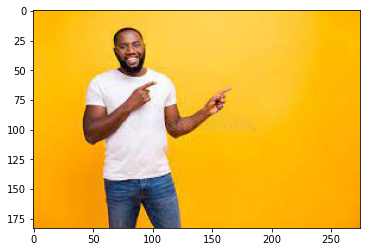

In [ ]:
## 이미지 확인 
plt.imshow(lms_sticker_images_rgb[test_image_stem])

# 뒷 부분에서 images[0]의 얼굴이 recognition tool로 추출되지 않는 오류가 있어서 images[1]을 사용 

In [ ]:
lms_sticker_resized_path = lms_sticker_path.joinpath('resized')
lms_sticker_resized_path.mkdir(exist_ok=True, parents=True)

for name, image in lms_sticker_images.items():
    # TODO: 이미지가 일그러짐, 비율에 맞춰 패딩 추가 후 리사이즈할 것!
    resizedImg = cv.resize(image, (320, 240))
    cv.imwrite(str(lms_sticker_resized_path.joinpath(f"{name}.jpeg")), resizedImg)


https://medium.com/@basit.javed.awan/resizing-multiple-images-and-saving-them-using-opencv-518f385c28d3

https://www.geeksforgeeks.org/resize-multiple-images-using-opencv-python/

In [ ]:
lms_sticker_resized_image_path_list = []
for image_path in lms_sticker_resized_path.glob('*.jpeg'):
    lms_sticker_resized_image_path_list.append(image_path)

lms_sticker_resized_images = {}
lms_sticker_resized_images_rgb = {}
for image_path in lms_sticker_resized_image_path_list:
    # 이미지 이름을 키로, 이미지를 밸류로 하는 딕셔너리
    lms_sticker_resized_images[int(image_path.stem)] = cv.imread(str(image_path))
    lms_sticker_resized_images_rgb[int(image_path.stem)] = cv.cvtColor(lms_sticker_resized_images[int(image_path.stem)], cv.COLOR_BGR2RGB)


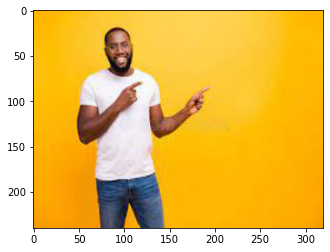

In [ ]:
plt.imshow(lms_sticker_resized_images_rgb[test_image_stem])

In [ ]:
## Facial Recognition function
# Bring 기존 얼굴 인식 tool

detector = dlib.get_frontal_face_detector()

#### 추후진행
- Set Multiple Images 문제 해결, 추후 이 부분 수정하여 진행하고자 함 우선 지금은 single image로 진행 

In [ ]:
## Facial Bounding Box Detect Rectangle 
# Multiple Images니까 각 이미지마다 bounding box 위치가 다름을 인지 
# Multiple image를 한번에 detector로 인지하고싶은데 read가 안됨
# 하나만 하면 되나 싶어서 아래에서 진행 -> 미리 말하자면 된다

lms_sticker_resized_images_face_rects = {}
lms_sticker_resized_images_dlib_rects = {}
for name, image in lms_sticker_resized_images_rgb.items():
    # img_rgb를 이용
    # 이미지 피라미드란 이미지를 upsampling하여 크기를 키우는 것 
    # 작게 촬영된 얼굴을 크게 볼 수 있음
    # 참고 : https://opencv-python.readthedocs.io/en/latest/doc/14.imagePyramid/imagePyramid.html
    # 이미지 피라미드 이용시 이미지 결합 처리 가능함 
    face_rects = detector(image, 1) # 1은 이미지 피라미드 수 
    if len(face_rects) > 0:
        lms_sticker_resized_images_face_rects[name] = []
        lms_sticker_resized_images_dlib_rects[name] = face_rects
        for face_rect in face_rects:
            lms_sticker_resized_images_face_rects[name].append({
                'left': face_rect.left(),
                'right': face_rect.right(),
                'top': face_rect.top(),
                'bottom': face_rect.bottom(),
            })



In [ ]:
pprint(lms_sticker_resized_images_face_rectsss)

{2: [{'bottom': 70, 'left': 156, 'right': 199, 'top': 26}],
 3: [{'bottom': 66, 'left': 77, 'right': 113, 'top': 30}],
 5: [{'bottom': 103, 'left': 223, 'right': 266, 'top': 60}],
 6: [{'bottom': 74, 'left': 117, 'right': 160, 'top': 31}],
 7: [{'bottom': 107, 'left': 55, 'right': 106, 'top': 55}],
 8: [{'bottom': 102, 'left': 89, 'right': 125, 'top': 66}],
 9: [{'bottom': 90, 'left': 152, 'right': 204, 'top': 38}],
 10: [{'bottom': 142, 'left': 135, 'right': 197, 'top': 80}],
 11: [{'bottom': 122, 'left': 73, 'right': 135, 'top': 59}],
 12: [{'bottom': 122, 'left': 121, 'right': 183, 'top': 59}],
 14: [{'bottom': 84, 'left': 98, 'right': 141, 'top': 41}],
 15: [{'bottom': 156, 'left': 116, 'right': 205, 'top': 66}]}


* RGB 이미지를 폴더에 저장해서 진행하면 쉬우려나? 생각해봤지만 NOPE 생각해보니 cv는 BGR 이미지 취급

#### Facial bounding box 추출 

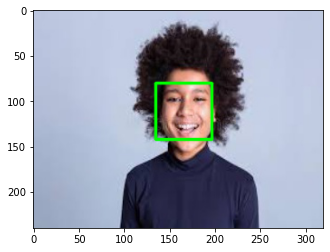

In [ ]:
lms_sticker_resized_images_with_rect = {}
for name, rects in lms_sticker_resized_images_face_rects.items():
    lms_sticker_resized_images_with_rect[name] = lms_sticker_resized_images[name].copy()
    for rect in rects:
        cv.rectangle(
            lms_sticker_resized_images_with_rect[name],
            (rect['left'], rect['top']),
            (rect['right'], rect['bottom']),
            (0, 255, 0),
            2,
            lineType = cv.LINE_AA
        )

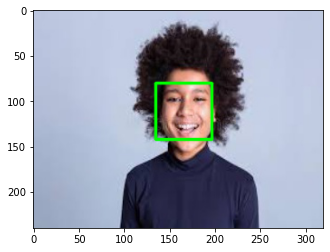

In [ ]:
for name in lms_sticker_resized_images_face_rects:
    rgb_box = cv.cvtColor(lms_sticker_resized_images_with_rect[name], cv.COLOR_BGR2RGB)
    plt.imshow(rgb_box)
    plt.show()
    break # 하나만 보고싶어서



마스크 쓴 이미지로 시도해봤는데, 입을 가려서인지 인지가 되지 않음 

In [ ]:
# Face landmark 이목구비 위치 확인
# bounding box 사용 
# top down, bottom up 방법 중 top down 사용할거다. bounding box search -> keypoint check
# Dlib라는 pretrained model 사용(Regression Tree 앙상블 사용)

#### Face landmark 이목구비 위치 확인
- bounding box 사용 
- top down, bottom up 방법 중 top down 사용할거다. bounding box search -> keypoint check
- Dlib라는 pretrained model 사용(Regression Tree 앙상블 사용)

In [ ]:
# landmark predictor 들고오기 (얼굴 point 인식)

model_path = root_path.joinpath('E3_sticker/shape_predictor_68_face_landmarks.dat')
landmark_predictor = dlib.shape_predictor(str(model_path))


In [ ]:
lms_sticker_resized_images_landmarks = {}

for name, dlib_rects in lms_sticker_resized_images_dlib_rects.items():
    lms_sticker_resized_images_landmarks[name] = []
    for dlib_rect in dlib_rects:
        points = landmark_predictor(lms_sticker_resized_images[name], dlib_rect)
        list_points = list(map(lambda p: (p.x, p.y), points.parts()))
        lms_sticker_resized_images_landmarks[name].append(list_points)

In [ ]:
for name in lms_sticker_resized_images_dlib_rects:
    landmarks = lms_sticker_resized_images_landmarks[name]
    print(landmarks[0])
    print(f"포인트 수는 {len(landmarks[0])}")
    break

[(140, 102), (139, 110), (139, 118), (141, 126), (144, 134), (149, 141), (155, 148), (162, 153), (169, 155), (176, 154), (183, 149), (189, 142), (194, 135), (198, 128), (199, 120), (200, 111), (200, 103), (145, 94), (147, 89), (153, 87), (158, 87), (163, 89), (175, 89), (180, 87), (186, 87), (192, 89), (195, 94), (169, 97), (168, 102), (168, 107), (167, 113), (162, 117), (165, 118), (168, 119), (171, 118), (175, 117), (150, 99), (154, 98), (157, 98), (161, 100), (157, 100), (154, 100), (177, 99), (181, 98), (184, 98), (188, 99), (185, 100), (181, 100), (156, 126), (160, 124), (165, 123), (169, 123), (173, 123), (179, 124), (184, 126), (180, 135), (174, 139), (169, 139), (165, 139), (160, 135), (157, 127), (165, 125), (169, 126), (173, 125), (182, 127), (173, 135), (169, 135), (165, 135)]
포인트 수는 68


#### Facial Points Check

In [ ]:
lms_sticker_resized_images_with_landmark = {}

for name, landmarks in lms_sticker_resized_images_landmarks.items():
    lms_sticker_resized_images_with_landmark[name] = lms_sticker_resized_images[name].copy()
    for landmark in landmarks:
        for point in landmark:
            cv.circle(
                lms_sticker_resized_images_with_landmark[name],
                point,
                2, # 반지름
                (0, 255, 255), # 색
                -1 # 내부를 채워줘요
            )

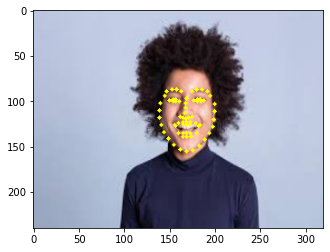

In [ ]:
for name in lms_sticker_resized_images_landmarks:
    rgb_box = cv.cvtColor(lms_sticker_resized_images_with_landmark[name], cv.COLOR_BGR2RGB)
    plt.imshow(rgb_box)
    plt.show()
    break # 하나만 보고싶어서

#### Center point check 

(167, 113)


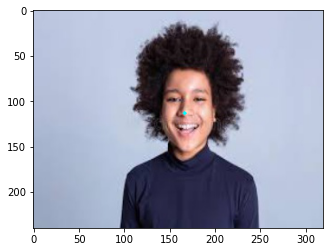

In [ ]:
for name, landmarks in lms_sticker_resized_images_landmarks.items():
    image = lms_sticker_resized_images[name].copy()
    for landmark in landmarks:
        point = landmark[30]
        print(point)
        cv.circle(
            image,
            point,
            2, # 반지름
            (255, 255, 0), # 색
            -1 # 내부를 채워줘요
        )
    rgb_box = cv.cvtColor(image, cv.COLOR_BGR2RGB)
    plt.imshow(rgb_box)
    plt.show()
    break

#### Current point check 

In [ ]:
whiskers_path = root_path.joinpath('E3_sticker/cat-whiskers.png')

#### Bring Whisker image

(130, 512, 3)


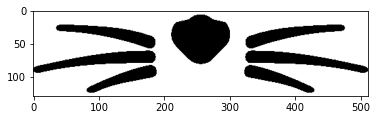

In [ ]:
whiskers_image = cv.imread(str(whiskers_path))[190:320, :, :]
plt.imshow(whiskers_image)
print(whiskers_image.shape)
whiskers_center_point = (256, 50) # x, y

Image의 형식이 jpeg라서 whisker 이미지 또한 png에서 jpeg로 변경했지만(혹시 형식이 부딪힐 수 있을 듯 하여) 추후 뒤에서 배경이 투명한 이미지로서 배경 이미지와 합쳐져야 하기 때문에 jpeg로 변경하지 않고 png 형식으로 사용. 아래 코드는 jpeg로 변경하기 위해 사용했던 내용.

#### sticker size modification

(43, 43, 3)


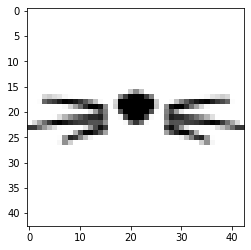

In [ ]:
# sticker size modification
whis = cv.resize(whis, (43,43), interpolation = cv.INTER_AREA)
plt.imshow(whis)
print(whis.shape)

# 이미지를 너무 줄였더니 깨짐. cv.INTER_AREA로 해도 깨짐
# 기존 w, h에 맞추면 (44, 14)인데 이러면 다 깨져서 원래 정방이미지였으니 (44, 44)에 맞추니 아래와 같은 형태는 보임
# 그런데 추후 whiskers 반으로 나누면 홀수이기 떄문에(0-44) 43으로 수정
# 다른 이미지를 다운받을까 하다가 그냥 해당 이미지로 진행하고자 함 

참고: https://enjoyimageprocessing.tistory.com/entry/OpenCV-%EA%B8%B0%EC%B4%88-Image-ProcessingResize


In [ ]:
import numpy as np
import cv2
import math

def rotate_image(image, angle):
    image_center = tuple(np.array(image.shape[1::-1]) / 2)
    rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)
    result = cv2.warpAffine(image, rot_mat, image.shape[1::-1], flags=cv2.INTER_LINEAR)
    return result

-0.9548412538721885


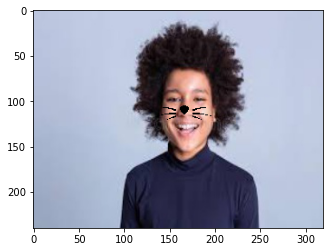

In [ ]:
for name, landmarks in lms_sticker_resized_images_landmarks.items():
    image = lms_sticker_resized_images[name].copy()
    face_rect = lms_sticker_resized_images_face_rects[name][0]
    landmark = landmarks[0]
    
    nose_point = landmark[30]
    width = face_rect['right'] - face_rect['left']
    height = (face_rect['bottom'] - face_rect['top']) // 3
    
    d_x = landmark[16][0] - landmark[0][0]
    d_y = - landmark[16][1] + landmark[0][1]

    degree = math.atan2(d_y, d_x) / math.pi * 180
    
    print(degree)
    
    resized_whiskers_image = cv.resize(whiskers_image.copy(), (width, height), interpolation = cv.INTER_AREA)

    left = nose_point[0] - width // 2
    right = nose_point[0] + width // 2
    top = nose_point[1] - height // 2
    bottom = nose_point[1] + height // 2

    masking_nose = cv.copyTo(image[top: bottom, left:right], resized_whiskers_image, resized_whiskers_image)
    image[top: bottom, left:right] = masking_nose

    # rotate_image()
    rgb_box = cv.cvtColor(image, cv.COLOR_BGR2RGB)
    plt.imshow(rgb_box)
    break

* BRGA 
  - alpha값이 하나가 더 추가된 색
  - 배경이 투명한 이미지는 A가 0이면 배경이 투명. A가 255면 불투명. 
  - 즉, A가 1이상이면 255, 1 미만이면 0으로 바꾸면 배경은 검은색, 전경은 흰색 

>> 주의할 부분
* 좌표 설정할 때 x, y라고 자동적으로 x가 행 y가 열이라고 세팅하면 안됨. 이 상황에서는 y가 행의 위치를 의미하고 x가 열의 위치를 의미함 

CNN 방법 추후 진행 

In [ ]:
# import the necessary packages
# from pyimagesearch.helpers import convert_and_trim_bb
# import argparse
# import imutils
# import time
# import dlib
# import cv2

#### 개선점 
  - 가능하다면 이미지 크기가 어느정도 있는 데이터로 진행하는 게 좋을 것 같음 
  - Another Methods inclusing CNN